In [3]:
!pip install pandas seaborn numpy matplotlib statsmodels joblib warnings

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import aic, bic
import joblib
import warnings

warnings.filterwarnings('ignore')

In [9]:
df = pd.read_excel('../datasets/data.xlsx', sheet_name=None)
print(df.keys())

dict_keys(['Dim_Category', 'Dim_County', 'Dim_Date', 'Dim_Parameter', 'Dim_Site', 'Dim_State', 'Fact_AQI'])


In [10]:
# get sheet
df_aqi = df['Fact_AQI']
df_county = df['Dim_County']
df_date = df['Dim_Date']
df_state = df['Dim_State']
# merge sheet

df_merged = pd.merge(df_aqi, df_county[['County_SK', 'County','State_SK']], on='County_SK', how='left')
df_merged = pd.merge(df_merged, df_date[['Date_SK', 'Full_Date']], on='Date_SK', how='left')
df_merged  =  pd.merge(df_merged, df_state[['State_SK', 'State_Name']], on='State_SK', how='left')

# format
df_merged['Full_Date'] = pd.to_datetime(df_merged['Full_Date'])
df_merged = df_merged[['State_Name','Full_Date', 'AQI']]

print(df_merged.head(5))

  State_Name  Full_Date  AQI
0     Alaska 2021-01-01    7
1     Alaska 2021-01-04    8
2     Alaska 2021-01-07   11
3     Alaska 2021-01-10    4
4     Alaska 2021-01-13    4


In [4]:
# Kiểm tra tính dừng bằng ADF test
def adf_test(series):
    result = adfuller(series)
    if result[1] > 0.05:
        return False  # Không dừng
    else:
        return True  # Dừng

# Kiểm tra tính dừng và thực hiện sai phân cho đến khi chuỗi dừng
def make_stationary(series, max_diff=3):
    diff_series = series
    for i in range(max_diff):
        if adf_test(diff_series):
            return diff_series
        diff_series = diff_series.diff().dropna()
    return diff_series  # Trả về chuỗi đã sai phân tối đa max_diff lần

# Tự động tìm tham số p, d, q tối ưu dựa trên AIC/BIC
def find_best_arima_params(aqi_series, p_max=5, q_max=5):
    # Kiểm tra tính dừng của chuỗi và làm cho chuỗi dừng
    aqi_series = make_stationary(aqi_series)

    best_aic = np.inf
    best_bic = np.inf
    best_order = None

    # Thử các giá trị p, q trong phạm vi cho phép và chọn AIC/BIC nhỏ nhất
    for p in range(p_max+1):
        for q in range(q_max+1):
            try:
                # Tạo mô hình ARIMA
                model = ARIMA(aqi_series, order=(p, 1, q))  # d = 1 vì đã kiểm tra tính dừng
                model_fit = model.fit()

                # Kiểm tra AIC và BIC
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_order = (p, 1, q)
            except Exception as e:
                continue

    return best_order

# Hàm huấn luyện mô hình ARIMA và lưu mô hình
def train_and_save_arima_model(county_name, aqi_series):
    # Tìm tham số tốt nhất (p, d, q) tự động
    p, d, q = find_best_arima_params(aqi_series)
    print(p, d, q)
    # Huấn luyện mô hình ARIMA với tham số tốt nhất
    model = ARIMA(aqi_series, order=(p, d, q))
    model_fit = model.fit()

    # Lưu mô hình
    model_path = f'../models/{county_name}_arima.pkl'
    joblib.dump(model_fit, model_path)

In [5]:
# Huấn luyện và lưu mô hình ARIMA cho từng county
unique_states = df_merged['State_Name'].unique()
for state in unique_states:
    print(f'Training ARIMA model for {state}...')
    df_filtered = df_merged[df_merged['State_Name'] == state].set_index('Full_Date').sort_index()
    
    # Resample dữ liệu theo tuần và tính giá trị trung bình của AQI mỗi tuần
    df_resampled = df_filtered.resample('W').mean(numeric_only=True)  # Thêm numeric_only=True
    
    # Lấy chuỗi AQI để huấn luyện ARIMA
    aqi_series = df_resampled['AQI']
    aqi_series = aqi_series.fillna(aqi_series.mean())
    # Huấn luyện mô hình ARIMA
    train_and_save_arima_model(state, aqi_series)

Training ARIMA model for Alaska...
3 1 0
Training ARIMA model for Arizona...
4 1 5
Training ARIMA model for California...
5 1 5
Training ARIMA model for Delaware...
3 1 3
Training ARIMA model for Hawaii...
0 1 1
Training ARIMA model for Illinois...
3 1 4
Training ARIMA model for Ohio...
5 1 3
Training ARIMA model for Texas...
3 1 2
Training ARIMA model for Alabama...
0 1 2
Training ARIMA model for Arkansas...
0 1 2
Training ARIMA model for Colorado...
2 1 1
Training ARIMA model for Idaho...
0 1 3
Training ARIMA model for Indiana...
2 1 5
Training ARIMA model for Oklahoma...
0 1 1
Training ARIMA model for Utah...
0 1 3
Training ARIMA model for Virginia...
2 1 1
Training ARIMA model for Georgia...
3 1 1
Training ARIMA model for North Dakota...
3 1 2


In [3]:
# Hàm để tải mô hình ARIMA dựa trên tên location
def load_arima_model(location):
    model_path = f'../models/{location}_arima.pkl'  # Xác định đường dẫn tự động theo tên location
    try:
        model = joblib.load(model_path)  # Tải mô hình từ file
        print(f'Model for {location} loaded successfully.')
        return model
    except FileNotFoundError:
        print(f'Model for {location} not found at {model_path}.')
        return None

In [7]:
location = input("Nhập tên location: ")

# Tải mô hình ARIMA cho location
model = load_arima_model(location)

if model:
    # Dự báo 1 tháng (4 tuần)
    forecast_1_month = model.forecast(steps=4)
    print(f'1 Month Forecast for {location}:')
    print(forecast_1_month)

    # Dự báo 1 quý (12 tuần)
    forecast_1_quarter = model.forecast(steps=12)
    print(f'1 Quarter Forecast for {location}:\n')
    print(forecast_1_quarter)

Model for California loaded successfully.
1 Month Forecast for California:
2024-01-07    55.509224
2024-01-14    58.326487
2024-01-21    56.491312
2024-01-28    57.367915
Freq: W-SUN, Name: predicted_mean, dtype: float64
1 Quarter Forecast for California:

2024-01-07    55.509224
2024-01-14    58.326487
2024-01-21    56.491312
2024-01-28    57.367915
2024-02-04    58.806767
2024-02-11    56.426901
2024-02-18    58.229568
2024-02-25    58.698291
2024-03-03    56.931517
2024-03-10    58.485949
2024-03-17    58.296585
2024-03-24    57.631189
Freq: W-SUN, Name: predicted_mean, dtype: float64


Vẽ dữ liệu dự đoán trong 1 quý

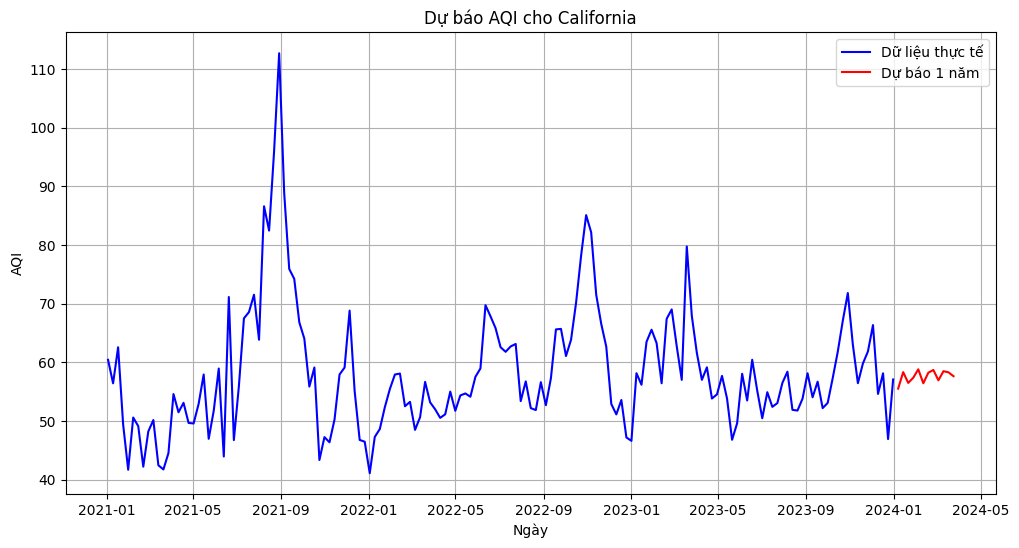

In [11]:
# Tải dữ liệu thực tế (ví dụ là df_merged với dữ liệu AQI cho từng state và full date)
df_filtered = df_merged[df_merged['State_Name'] == location].set_index('Full_Date').sort_index().resample('W').mean(numeric_only=True)

# Dự báo 1 quý (12 tuần)
forecast_1_quarter = model.forecast(steps=12)

# Vẽ dữ liệu thực tế
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['AQI'], label='Dữ liệu thực tế', color='blue')

# Tạo chuỗi thời gian cho dự báo 1 quý (12 tuần)
forecast_index_1_quarter = pd.date_range(start=df_filtered.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')

# Vẽ dự báo 1 quý
plt.plot(forecast_index_1_quarter, forecast_1_quarter, label='Dự báo 1 năm', color='red')

# Thêm nhãn và tiêu đề
plt.title(f'Dự báo AQI cho {location}')
plt.xlabel('Ngày')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()